Load the data

In [1]:
from preprocessing import load_folder_paths, load_dcm_datasets, get_volume
from scipy import ndimage
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import numpy as np

paths = load_folder_paths()
dataset_path = os.path.expanduser('~/Desktop/UniToBrain')
path = os.path.join(dataset_path, 'MOL-106')
v = get_volume(path, extract_brain=False, filter=True, window_params=(80, 160), correct_motion=False, standardize=False, spatial_downsampling_factor=2, temporal_downsampling_factor=1)

Loading /Users/simonma/Desktop/UniToBrain/MOL-106...
Dicom files loaded, count: 288
Processing /Users/simonma/Desktop/UniToBrain/MOL-106...
5 [0.488281, 0.488281]


ic| volume_seq.max(): 160.0
    volume_seq.min(): 0.0
    volume_seq.dtype: dtype('float32')


Total time taken: 2.76 seconds
Average time taken per volume: 0.15 seconds
Done!


Interactive Visualization Functions

In [31]:
from ipywidgets import interact, IntSlider
from IPython.display import clear_output
from math import ceil

def overlay_volume_sequence_interactive(volume_seq):
    num_overlays = len(volume_seq) - 1
    nrows = ceil(num_overlays ** 0.5)
    ncols = ceil(num_overlays / nrows)
    print(f"{nrows=} {ncols=}")
    def plot_slice(slice_idx):

        fig, axes = plt.subplots(nrows, 
                                ncols, 
                                figsize=(5*ncols, 5*nrows),
                                squeeze=True)
        if nrows == 1:
            if ncols == 1:
                axes = [[axes]]
            else:
                axes = [axes]
        print(f"{axes=}")
        for i in range(num_overlays):
            ax = axes[i // ncols][i % ncols]
            print(f"{ax=}")
            ax.imshow(volume_seq[0][slice_idx], cmap="gray")
            ax.imshow(volume_seq[i+1][slice_idx], cmap="hot", alpha=0.5)
        plt.show(block=True)
    
    interact(
        plot_slice,
        slice_idx=IntSlider(
            min=0,
            max=len(volume_seq[0])-1, 
            step=1,
            value=0,
            description='Slice:'
        )
    )

def multi_vol_seq_interactive(volume_seqs, titles=None, consistent_intensity_scaling=False):
    """
    Interactive plot of multiple volume sequences using ipywidgets
    
    Parameters:
    - volume_seqs: List of 4D volume sequences to display
    - titles: Optional list of titles for each sequence
    """
    clear_output(wait=True)
    if titles is None:
        titles = [f"Volume {i+1}" for i in range(len(volume_seqs))]
        
    num_volumes = len(volume_seqs)
    nrows = int(num_volumes ** 0.5)
    ncols = (num_volumes + nrows - 1) // nrows
    
    min_max_values = []
    if not consistent_intensity_scaling:
        for volume_seq in volume_seqs:
            min_max_values.append((np.min(volume_seq), np.max(volume_seq)))
    else:
        min_max_values = [(np.min(volume_seqs), np.max(volume_seqs)) for _ in range(len(volume_seqs))]

    def plot_volumes(time_idx, slice_idx):
        fig, axes = plt.subplots(nrows, ncols, 
                                figsize=(5*ncols, 5*nrows),
                                squeeze=True)
        if nrows == 1:
            if ncols == 1:
                axes = [[axes]]
            else:
                axes = [axes]
                
        for i, (volume_seq, title) in enumerate(zip(volume_seqs, titles)):
            row, col = i // ncols, i % ncols
            ax = axes[row][col]
            
            t = min(time_idx, len(volume_seq) - 1)
            s = min(slice_idx, len(volume_seq[t]) - 1)

            vmin, vmax = min_max_values[i]

            im = ax.imshow(volume_seq[t][s], cmap='magma', vmin=vmin, vmax=vmax)
            ax.set_title(title)
            plt.colorbar(im, ax=ax)
            
        plt.tight_layout()
        # plt.show()
        
    max_time = max(len(vol) for vol in volume_seqs) - 1
    max_slice = max(len(vol[0]) for vol in volume_seqs) - 1
    
    interact(
        plot_volumes,
        time_idx=IntSlider(min=0, max=max_time, step=1, value=0, description='Time:'),
        slice_idx=IntSlider(min=0, max=max_slice, step=1, value=0, description='Slice:')
    )


In [32]:
multi_vol_seq_interactive([v])

interactive(children=(IntSlider(value=0, description='Time:', max=17), IntSlider(value=0, description='Slice:'…

In [19]:
from IPython.display import clear_output
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations

    metric_values = []
    multires_iterations = []


# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations

    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()


# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method, metric_name='Metric Value'):
    if registration_method.GetOptimizerIteration() % 10 == 0:
        global metric_values, multires_iterations

        metric_values.append(registration_method.GetMetricValue())
        # Clear the output area (wait=True, to reduce flickering), and plot current data
        clear_output(wait=True)
        # Plot the similarity metric values
        plt.plot(metric_values, "r")
        plt.plot(
            multires_iterations,
            [metric_values[index] for index in multires_iterations],
            "b*",
        )
        plt.xlabel("Iteration Number", fontsize=12)
        plt.ylabel(metric_name, fontsize=12)
        plt.show()


# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [20]:
def plot_volume_slices(volume, title=None, cmap='magma'):
    """
    Plots all slices of a 3D volume in a rectangular grid arrangement.
    
    Parameters:
    - volume: 3D numpy array of shape (D, H, W)
    - title: Optional string for overall figure title
    - cmap: Colormap to use for plotting
    """
    D = volume.shape[0]
    vmin, vmax = np.min(volume), np.max(volume)

    # Calculate grid dimensions to arrange plots in a roughly square layout
    n_rows = int(np.ceil(np.sqrt(D)))
    n_cols = int(np.ceil(D / n_rows))
    
    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    if title:
        fig.suptitle(title, fontsize=16)
    
    # Flatten axes array for easier iteration
    axes = axes.flatten()
    
    # Plot each slice
    for i in range(D):
        axes[i].imshow(volume[i], cmap=cmap, vmin=vmin, vmax=vmax)
        axes[i].axis('off')
        axes[i].set_title(f'Slice {i}')
    
    # Turn off any empty subplots
    for i in range(D, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# 3D Registration

In [21]:
def register_volume_3D(moving_volume: np.ndarray, reference_volume: np.ndarray,
               lr: float = 0.5, n_iters: int = 200, relaxation_factor: float = 0.9, 
               gradient_magnitude_tolerance: float = 1e-4, max_step: float = 4.0, min_step: float = 1e-4, 
               spacing: tuple = (0.976562, 0.976562, 5.0),
               multi_res: bool = False):
    
    def command_iteration(method):
        if (method.GetOptimizerIteration() + 1) % 50 == 0:
            print(f"Iteration: {method.GetOptimizerIteration()}")
            print(f"Metric value: {method.GetMetricValue():.4f}")

    # Set min pixel value to 0 so that background aligns with pixels moved in by transformation during registration
    # min_pixel_value = np.min(moving_volume)
    # moving_volume, reference_volume = moving_volume - min_pixel_value, reference_volume - min_pixel_value

    # Convert to SimpleITK images
    moving = sitk.GetImageFromArray(moving_volume)
    fixed = sitk.GetImageFromArray(reference_volume)
    # if not multi_res:
    #     moving_image = sitk.DiscreteGaussian(moving_image, smoothing_sigma)
    #     reference_image = sitk.DiscreteGaussian(reference_image, smoothing_sigma)

    moving.SetSpacing(spacing)
    fixed.SetSpacing(spacing)
    
    print("moving size (x, y, z):", moving.GetSize())
    # Initialize 2D transform
    initial_transform = sitk.CenteredTransformInitializer(
        fixed,
        moving,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )
    print(initial_transform)
    moving_array = sitk.GetArrayFromImage(moving)
    plot_volume_slices(moving_array, title="Moving Volume")

    # Setup registration method
    reg_method = sitk.ImageRegistrationMethod()
    reg_method.SetMetricAsMeanSquares()
    # reg_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    # reg_method.SetMetricSamplingPercentage(0.1)
    # reg_method.SetMetricSamplingStrategy(sitk.ImageRegistrationMethod.RANDOM)
    
    reg_method.SetInterpolator(sitk.sitkLinear)
    reg_method.SetInitialTransform(initial_transform)

   # Multi-resolution configuration
    # reg_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    # reg_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    # reg_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Optimizer settings
    reg_method.SetOptimizerAsRegularStepGradientDescent(
        learningRate=lr,
        maximumStepSizeInPhysicalUnits=max_step,
        minStep=min_step,
        numberOfIterations=n_iters,
        gradientMagnitudeTolerance=gradient_magnitude_tolerance,
        relaxationFactor=relaxation_factor,
    )

    reg_method.SetOptimizerScalesFromPhysicalShift()

    if multi_res:
        reg_method.SetShrinkFactorsPerLevel(shrinkFactors=[2, 1])
        reg_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[1, 2])


    reg_method.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(reg_method))
    reg_method.AddCommand(sitk.sitkStartEvent, start_plot)
    reg_method.AddCommand(sitk.sitkEndEvent, end_plot)
    reg_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations)
    reg_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(reg_method, 'MSE'))


    final_transform = reg_method.Execute(fixed, moving)
    print(f"Stopping condition: {reg_method.GetOptimizerStopConditionDescription()}")

    resampled = sitk.Resample(
        moving,
        fixed,
        final_transform,
        sitk.sitkBSpline,  # B-spline interpolation for final resampling
        0.0,               # Default value for out-of-range pixels
        moving.GetPixelID()
    )
    return sitk.GetArrayFromImage(resampled)

In [22]:
# v1 = register_volume_3D(v[1], v[0], lr=0.5, n_iters=200)

In [23]:
np.min(v1), np.max(v1)

NameError: name 'v1' is not defined

In [24]:
multi_vol_seq_interactive([[v[0], np.clip(v1, 0, 160)], v[:2]])

NameError: name 'v1' is not defined

## Drawbacks of 3D registration
Rotation along the y-axis (the height) of each volume causes interpolation between the slices.

In [26]:
v_unwindowed = get_volume(path, extract_brain=False, filter=False, window_params=None, correct_motion=False, standardize=False, spatial_downsampling_factor=2, temporal_downsampling_factor=1)

Loading /Users/simonma/Desktop/UniToBrain/MOL-106...
Dicom files loaded, count: 288
Processing /Users/simonma/Desktop/UniToBrain/MOL-106...
5 [0.488281, 0.488281]
Done!


In [27]:
multi_vol_seq_interactive([v_unwindowed, np.clip(v_unwindowed, 0, 160)])

interactive(children=(IntSlider(value=0, description='Time:', max=17), IntSlider(value=0, description='Slice:'…

In [28]:
from skimage import morphology
from scipy import ndimage
from numba import jit

@jit(nopython=True)
def get_threshold_mask(slice, min_val=-40, max_val=150):
    return (min_val < slice) & (slice < max_val)

@jit(nopython=True)
def apply_mask(a: np.ndarray, mask: np.ndarray):
    min_val = np.min(a)
    return (a - min_val) * mask + min_val

def mask_slice(slice, threshold_min=-40, threshold_max=150, structuring_element_dims=(3, 3)):
    smoothened = ndimage.gaussian_filter(slice, sigma=2.0)
    mask = get_threshold_mask(smoothened, min_val=threshold_min, max_val=threshold_max)
    mask = ndimage.binary_erosion(mask, np.ones(structuring_element_dims), iterations=2)
    # mask = ndimage.binary_erosion(mask, np.ones((3, 3)))
    # Remove small objects
    mask = morphology.remove_small_objects(mask, 800)
    # Fill small holes
    mask = ndimage.binary_dilation(mask, np.ones((3, 3)), iterations=2)
    mask = ndimage.binary_fill_holes(mask)
    return apply_mask(slice, mask)

def preprocess_slice_for_registration(slice, threshold_min=-40, threshold_max=150, structuring_element_dims=(3, 3), reg_window_min=20, reg_window_max=60):
    masked = mask_slice(slice, threshold_min=threshold_min, threshold_max=threshold_max, structuring_element_dims=structuring_element_dims)
    return np.clip(masked, reg_window_min, reg_window_max)

def mask_volume_seq(volume_seq: np.ndarray, threshold_min=-40, threshold_max=150, structuring_element_dims=(3, 3)):
    masked_volume_seq = np.zeros_like(volume_seq)
    for t, volume in enumerate(volume_seq):
        for i, slice in enumerate(volume):        
            masked_volume_seq[t, i] = mask_slice(slice, threshold_min=threshold_min, threshold_max=threshold_max, structuring_element_dims=structuring_element_dims)
    return masked_volume_seq

def preprocess_volume_seq(volume_seq: np.ndarray, threshold_min=-40, threshold_max=150, structuring_element_dims=(3, 3), reg_window_min=20, reg_window_max=60):
    masked_volume_seq = mask_volume_seq(volume_seq, threshold_min=threshold_min, threshold_max=threshold_max, structuring_element_dims=structuring_element_dims)
    return np.clip(masked_volume_seq, reg_window_min, reg_window_max)

v_masked = mask_volume_seq(v_unwindowed)
v_preprocessed = preprocess_volume_seq(v_unwindowed, reg_window_min=0, reg_window_max=50)

In [33]:
multi_vol_seq_interactive([np.clip(v_unwindowed, 0, 160), np.clip(v_masked, 0, 160), v_preprocessed], consistent_intensity_scaling=True)

interactive(children=(IntSlider(value=0, description='Time:', max=17), IntSlider(value=0, description='Slice:'…

In [45]:
def register_volume_inplane_weighted(moving_volume: np.ndarray, reference_volume: np.ndarray, n_samples: int = 5, 
               lr: float = 1.0, n_iters: int = 200, relaxation_factor: float = 0.99, 
               gradient_magnitude_tolerance: float = 1e-5, max_step: float = 4.0, min_step: float = 5e-4, 
               spacing: tuple = (1, 1), multi_res: bool = False, smoothing_sigma: float = 2.0, interpolator=sitk.sitkLinear,
               verbose: bool = False):
    
    Y, Z, X = moving_volume.shape
    
    if n_samples > Y: n_samples = Y
    elif n_samples < 1: n_samples = 1
    middle = Y // 2
    half_range = n_samples // 2
    slice_indices = np.linspace(middle - half_range, middle + half_range, n_samples, dtype=int)
    

    transforms = []
    weights = np.zeros(n_samples)

    def command_iteration(method):
        if (method.GetOptimizerIteration() + 1) % 50 == 0:
            print(f"Iteration: {method.GetOptimizerIteration()}")
            print(f"Metric value: {method.GetMetricValue():.4f}")

    # Register each sampled slice
    for pos, slice_idx in enumerate(slice_indices):
        print(f"Registering slice {slice_idx} of {Y}")
        
        # Standard preprocessing for registration
        moving_slice = preprocess_slice_for_registration(moving_volume[slice_idx])
        reference_slice = preprocess_slice_for_registration(reference_volume[slice_idx])

        # Set min pixel value to 0 so that background aligns with pixels moved in by transformation during registration
        min_pixel_value = np.min(moving_slice)
        moving_slice, reference_slice = moving_slice - min_pixel_value, reference_slice - min_pixel_value
        if verbose:
            print(f"{min_pixel_value=}")
        # Convert to SimpleITK images
        moving_image = sitk.GetImageFromArray(moving_slice)
        reference_image = sitk.GetImageFromArray(reference_slice)
        
        if smoothing_sigma:
            moving_image = sitk.DiscreteGaussian(moving_image, smoothing_sigma)
            reference_image = sitk.DiscreteGaussian(reference_image, smoothing_sigma)
        
        # Set 2D spacing
        moving_image.SetSpacing(spacing)
        reference_image.SetSpacing(spacing)
        
        # Initialize 2D transform
        initial_transform = sitk.CenteredTransformInitializer(
            reference_image,
            moving_image,
            sitk.Euler2DTransform(),
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
        
        # Setup registration method
        registration_method = sitk.ImageRegistrationMethod()
        registration_method.SetMetricAsMeanSquares()
        
        # Optimizer settings
        registration_method.SetOptimizerAsRegularStepGradientDescent(
            learningRate=lr,
            maximumStepSizeInPhysicalUnits=max_step,
            minStep=min_step,
            numberOfIterations=n_iters,
            gradientMagnitudeTolerance=gradient_magnitude_tolerance,
            relaxationFactor=relaxation_factor,
            
        )

        registration_method.SetInitialTransform(initial_transform)
        registration_method.SetInterpolator(interpolator)
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(registration_method))
        registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
        registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations)
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method, 'MSE'))

        if verbose:
            registration_method.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(registration_method))
        try:
            final_transform = registration_method.Execute(reference_image, moving_image)
            
            # position_weight = 1 / ((slice_idx - middle) / (half_range / 2)) # The further away from the center, the lower the weight
            metric_value = registration_method.GetMetricValue()
            # weight = 1 / ((metric_value) + 1e-10 ** 0.5) * position_weight
            weight = 1 / (metric_value + 1e-10)
            weights[pos] = weight


            if verbose:
                print(f"Stopping condition: {registration_method.GetOptimizerStopConditionDescription()}")
                print(f"Metric value: {metric_value:.4f}")
            # Store transform parameters and weight
            params = final_transform.GetParameters()
            center = final_transform.GetCenter()
            transforms.append((params, center))

            # Check for extreme transformations
            angle_deg = np.degrees(params[0])  # Convert angle from radians to degrees
            tx, ty = params[1], params[2]
            
            if abs(angle_deg) > 15 or abs(tx) > 10 or abs(ty) > 10:
                print(f"Info: Large transformation detected for slice {slice_idx}:")
                print(f"    Angle: {angle_deg:.2f}°, Translation: ({tx:.2f}, {ty:.2f})")
            
        except RuntimeError as e:
            print(f"Registration failed for slice {slice_idx}: {e}")
            continue
        
    # Normalize weights
    weights = weights / np.sum(weights)
    
    # Compute weighted average transformation
    avg_angle = 0
    avg_tx = 0
    avg_ty = 0
    avg_cx = 0
    avg_cy = 0
    

    for (params, center), weight in zip(transforms, weights):
        angle, tx, ty = params[0], params[1], params[2]
        avg_angle += angle * weight
        avg_tx += tx * weight
        avg_ty += ty * weight
        avg_cx += center[0] * weight
        avg_cy += center[1] * weight
    
    if verbose:
        print(f"{avg_angle=:.4f} {avg_tx=:.4f} {avg_ty=:.4f} {avg_cx=:.4f} {avg_cy=:.4f}")
    # print(f"Time taken: {time() - t1}")
        # Create final average transform
    final_transform = sitk.Euler2DTransform()
    final_transform.SetAngle(avg_angle)
    final_transform.SetTranslation((avg_tx, avg_ty))
    final_transform.SetCenter((avg_cx, avg_cy))
    
    # Apply transform to each slice of moving volume
    registered_volume = np.zeros_like(moving_volume)
    for i in range(moving_volume.shape[0]):
        moving_slice = sitk.GetImageFromArray(moving_volume[i])
        registered_slice = sitk.Resample(
            moving_slice,
            reference_image,
            final_transform,
            interpolator,
            0.0, # Min pixel value
            moving_slice.GetPixelID()
        )
        # Bring the slice back to its original value range by adding min_pixel_value
        registered_volume[i] = sitk.GetArrayFromImage(registered_slice) + min_pixel_value

    return registered_volume

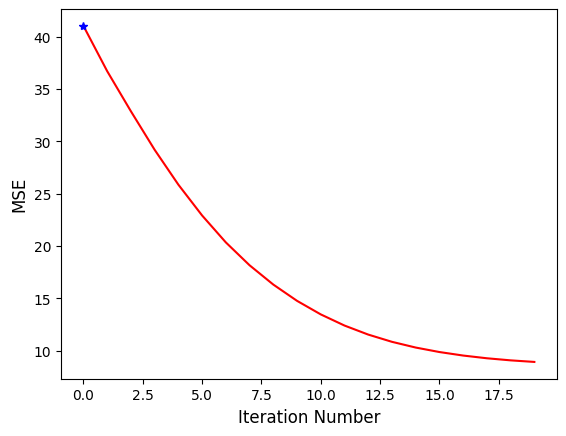

Iteration: 199
Metric value: 18.4065
Iteration: 199
Metric value: 18.4065
Stopping condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (200) exceeded.
Metric value: 18.4065
avg_angle=0.0162 avg_tx=5.3763 avg_ty=2.3425 avg_cx=127.5000 avg_cy=127.5000


In [46]:
v_1_reg = register_volume_inplane_weighted(v[1], v[0], verbose=True)

In [47]:
multi_vol_seq_interactive([np.clip(v_unwindowed[:2], 0, 160), np.clip(np.array([v_unwindowed[0], v_1_reg]), 0, 160)])

interactive(children=(IntSlider(value=0, description='Time:', max=1), IntSlider(value=0, description='Slice:',…

In [39]:
def rigid_register_volume_sequence(volume_seq: np.ndarray, 
                                   reference_index: int = 1,
                                   n_iters: int = 200,
                                   n_samples: int = 1,
                                   lr: float = 1.0,
                                   verbose: bool = True) -> np.ndarray:
    """
    Performs skull-based rigid registration on a sequence of volumes using the specified reference volume.

    Parameters:
    - volume_seq (np.ndarray): 4D array of shape (T, Y, Z, X) representing the volume sequence.
    - spacing (tuple): Physical spacing of the volume (Y, Z, X). Defaults to (5.0, 0.488281, 0.488281).
    - reference_index (int): Index of the reference volume in the sequence to which other volumes will be registered.
    - registering_structure (str): The structure used in registration. One of: 'all', 'skull', 'brain'. Defaults to 'all'.
    - window_center (int): The center of the window in HU. Defaults to 40.
    - window_width (int): The width of the window in HU. Defaults to 400.

    Returns:
    - np.ndarray: 4D array of registered volumes with the same shape as the input.
    """
    if not (0 <= reference_index < volume_seq.shape[0]):
        raise IndexError(f"Reference index {reference_index} is out of bounds for volume sequence with length {volume_seq.shape[0]}.")
    
    reference_volume = volume_seq[reference_index]

    print(f"Reference volume: {reference_volume.shape}")
    # Initialize the output array
    registered_seq = np.empty_like(volume_seq)
    registered_seq[reference_index] = volume_seq[reference_index]

    # Register each volume sequentially
    for i in range(volume_seq.shape[0]):
        if i == reference_index:
            continue
            
        print(f"Registering volume {i}")
        registered_seq[i] = register_volume_inplane_weighted(
            moving_volume=volume_seq[i],
            reference_volume=reference_volume,
            n_samples=n_samples,
            lr=lr,
            n_iters=n_iters,
            verbose=verbose,
        )

    print("All registrations completed.")
    return registered_seq

In [40]:
v_reg = rigid_register_volume_sequence(v_unwindowed, reference_index=0, verbose=True)

Reference volume: (16, 256, 256)
Registering volume 1
Registering slice 8 of 16
min_pixel_value=20.0
Iteration: 49
Metric value: 39.8385
Iteration: 99
Metric value: 28.0719
Iteration: 149
Metric value: 18.5905
Iteration: 199
Metric value: 12.3306
Stopping condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (200) exceeded.
Metric value: 12.3306
avg_angle=nan avg_tx=nan avg_ty=nan avg_cx=nan avg_cy=nan
Registering volume 2
Registering slice 8 of 16
min_pixel_value=20.0
Iteration: 49
Metric value: 37.8981


/var/folders/bh/qf1v6xm50lz_nh8mfd1m_fgm0000gn/T/ipykernel_57442/2150329430.py:81: RuntimeWarning: invalid value encountered in divide
  position_weight = 1 / ((slice_idx - middle) / (half_range / 2)) # The further away from the center, the lower the weight


Iteration: 99
Metric value: 27.1606
Iteration: 149
Metric value: 18.3800
Iteration: 199
Metric value: 12.6330
Stopping condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (200) exceeded.
Metric value: 12.6330
avg_angle=nan avg_tx=nan avg_ty=nan avg_cx=nan avg_cy=nan
Registering volume 3
Registering slice 8 of 16
min_pixel_value=20.0
Iteration: 49
Metric value: 37.1788
Iteration: 99
Metric value: 26.6126
Iteration: 149
Metric value: 18.5125
Iteration: 199
Metric value: 13.0270
Stopping condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (200) exceeded.
Metric value: 13.0270
avg_angle=nan avg_tx=nan avg_ty=nan avg_cx=nan avg_cy=nan
Registering volume 4
Registering slice 8 of 16
min_pixel_value=20.0
Iteration: 49
Metric value: 33.6580
Iteration: 99
Metric value: 23.8942
Iteration: 149
Metric value: 18.7092
Iteration: 199
Metric value: 14.0574
Stopping condition: RegularStepGradientDescentOptimizerv4: Maximum number of iterations (200) 

In [42]:
multi_vol_seq_interactive([np.clip(v_unwindowed, 0, 160), np.clip(v_reg, 0, 160)])

interactive(children=(IntSlider(value=0, description='Time:', max=17), IntSlider(value=0, description='Slice:'…

In [156]:
def register_volume_inplane_weighted(moving_volume: np.ndarray, reference_volume: np.ndarray, n_samples: int = 5, 
               lr: float = 1.0, n_iters: int = 200, relaxation_factor: float = 0.99, 
               gradient_magnitude_tolerance: float = 1e-5, max_step: float = 4.0, min_step: float = 5e-4, 
               spacing: tuple = (1, 1), multi_res: bool = False, smoothing_sigma: float = 2.0, interpolator=sitk.sitkLinear,
               verbose: bool = False):
    
    Y, Z, X = moving_volume.shape
    
    if n_samples > Y: n_samples = Y
    elif n_samples < 1: n_samples = 1
    middle = Y // 2
    half_range = n_samples // 2
    slice_indices = np.linspace(middle - half_range, middle + half_range, n_samples, dtype=int)
    
    mean_metric_value = 0

    def command_iteration(method):
        if (method.GetOptimizerIteration() + 1) % 50 == 0:
            print(f"Iteration: {method.GetOptimizerIteration()}")
            print(f"Metric value: {method.GetMetricValue():.4f}")

    # Register each sampled slice
    for pos, slice_idx in enumerate(slice_indices):
        print(f"Registering slice {slice_idx} of {Y}")
        # Get corresponding slices
        moving_slice = moving_volume[slice_idx]
        reference_slice = reference_volume[slice_idx]
        # Set min pixel value to 0 so that background aligns with pixels moved in by transformation during registration
        min_pixel_value = np.min(moving_slice)
        moving_slice, reference_slice = moving_slice - min_pixel_value, reference_slice - min_pixel_value
        if verbose:
            print(f"{min_pixel_value=}")
        # Convert to SimpleITK images
        moving_image = sitk.GetImageFromArray(moving_slice)
        reference_image = sitk.GetImageFromArray(reference_slice)
        
        if smoothing_sigma:
            moving_image = sitk.DiscreteGaussian(moving_image, smoothing_sigma)
            reference_image = sitk.DiscreteGaussian(reference_image, smoothing_sigma)
        
        # Set 2D spacing
        moving_image.SetSpacing(spacing)
        reference_image.SetSpacing(spacing)
        
        # Initialize 2D transform
        initial_transform = sitk.CenteredTransformInitializer(
            reference_image,
            moving_image,
            sitk.Euler2DTransform(),
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
        
        # Setup registration method
        registration_method = sitk.ImageRegistrationMethod()
        registration_method.SetMetricAsMeanSquares()
        
        # Optimizer settings
        registration_method.SetOptimizerAsRegularStepGradientDescent(
            learningRate=lr,
            maximumStepSizeInPhysicalUnits=max_step,
            minStep=min_step,
            numberOfIterations=n_iters,
            gradientMagnitudeTolerance=gradient_magnitude_tolerance,
            relaxationFactor=relaxation_factor,
            
        )

        registration_method.SetInitialTransform(initial_transform)
        registration_method.SetInterpolator(interpolator)
        
        if verbose:
            registration_method.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(registration_method))
        try:
            final_transform = registration_method.Execute(reference_image, moving_image)
            metric_value = registration_method.GetMetricValue()
            mean_metric_value += metric_value / n_samples
            
            # position_weight = 1 / ((slice_idx - middle) / (half_range / 2)) # The further away from the center, the lower the weight
            # metric_value = registration_method.GetMetricValue()
            # weight = 1 / ((metric_value) + 1e-10 ** 0.5) * position_weight
            # weights[pos] = weight


            # if verbose:
            #     print(f"Stopping condition: {registration_method.GetOptimizerStopConditionDescription()}")
            #     print(f"Metric value: {metric_value:.4f}")
            # # Store transform parameters and weight
            # params = final_transform.GetParameters()
            # center = final_transform.GetCenter()
            # transforms.append((params, center))
            # metric_values.append(metric_value)

            # # Check for extreme transformations
            # angle_deg = np.degrees(params[0])  # Convert angle from radians to degrees
            # tx, ty = params[1], params[2]
            
            # if abs(angle_deg) > 15 or abs(tx) > 10 or abs(ty) > 10:
            #     print(f"Info: Large transformation detected for slice {slice_idx}:")
            #     print(f"    Angle: {angle_deg:.2f}°, Translation: ({tx:.2f}, {ty:.2f})")
            
        except RuntimeError as e:
            print(f"Registration failed for slice {slice_idx}: {e}")
            continue
        
    # # Normalize weights
    # weights = weights / np.sum(weights)
    
    # # Compute weighted average transformation
    # avg_angle = 0
    # avg_tx = 0
    # avg_ty = 0
    # avg_cx = 0
    # avg_cy = 0
    

    # for (params, center), weight in zip(transforms, weights):
    #     angle, tx, ty = params[0], params[1], params[2]
    #     avg_angle += angle * weight
    #     avg_tx += tx * weight
    #     avg_ty += ty * weight
    #     avg_cx += center[0] * weight
    #     avg_cy += center[1] * weight
    
    # if verbose:
    #     print(f"{avg_angle=:.4f} {avg_tx=:.4f} {avg_ty=:.4f} {avg_cx=:.4f} {avg_cy=:.4f}")
    # # print(f"Time taken: {time() - t1}")
    #     # Create final average transform
    # final_transform = sitk.Euler2DTransform()
    # final_transform.SetAngle(avg_angle)
    # final_transform.SetTranslation((avg_tx, avg_ty))
    # final_transform.SetCenter((avg_cx, avg_cy))
    
    # # Apply transform to each slice of moving volume
    # registered_volume = np.zeros_like(moving_volume)
    # for i in range(moving_volume.shape[0]):
    #     moving_slice = sitk.GetImageFromArray(moving_volume[i])
    #     registered_slice = sitk.Resample(
    #         moving_slice,
    #         reference_image,
    #         final_transform,
    #         interpolator,
    #         0.0, # Min pixel value
    #         moving_slice.GetPixelID()
    #     )
    #     # Bring the slice back to its original value range by adding min_pixel_value
    #     registered_volume[i] = sitk.GetArrayFromImage(registered_slice) + min_pixel_value

    return mean_metric_value

In [157]:
def mse(moving_volume: np.ndarray, reference_volume: np.ndarray):
    return np.mean(np.square(moving_volume - reference_volume))

In [ ]:
# Setup
learning_rates = [2.0, 1.5, 1.0, 0.5]
n_samples = [1, 3, 5, 7, 9]
relaxation_factors = [0.99, 0.97, 0.95, 0.92, 0.9]
smoothing_sigmas = [2.0, 1.5, 1.0, 0.5, 0]
iterations = [100, 200, 500, 1000, 1500]
interpolators = [sitk.sitkLinear, sitk.sitkBSpline, sitk.sitkNearestNeighbor]
paths = [dataset_path + "/MOL-" + s for s in ['062', '063', '092', '098', '104', '133']]
scans = [get_volume(path, 
                   extract_brain=False, 
                   filter=True, 
                   window_params=(), 
                   correct_motion=False, 
                   standardize=False, 
                   spatial_downsampling_factor=2, 
                   temporal_downsampling_factor=8
                   ) for path in paths]

Loading /Users/simonma/Desktop/UniToBrain/MOL-062...
Dicom files loaded, count: 288
Processing /Users/simonma/Desktop/UniToBrain/MOL-062...
5 [0.488281, 0.488281]


ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
results = []
# Experiment
for scan_id in scan_ids:
    v = get_volume(scan_id, 
                   extract_brain=False, 
                   filter=True, 
                   window_params=(80, 160), 
                   correct_motion=False, 
                   standardize=False, 
                   spatial_downsampling_factor=2, 
                   temporal_downsampling_factor=8
                   )
    for lr in learning_rates:
        for n in n_samples:
            for relax in relaxation_factors:
                for sigma in smoothing_sigmas:
                    for interp in interpolators:
                        mean_metric = register_volume_inplane_weighted(v[0], v[1], 
                                                                     lr=lr, n_samples=n, 
                                                                     relaxation_factor=relax, 
                                                                     smoothing_sigma=sigma, 
                                                                     interpolator=interp)
                        results.append({
                            'scan_id': scan_id,
                            'lr': lr,
                            'n_samples': n,
                            'relaxation_factor': relax,
                            'smoothing_sigma': sigma,
                            'interpolator': interp,
                            'mean_metric': mean_metric})